In [8]:
# imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor
from scipy.stats import uniform, randint
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor


## INTRODUCTION ##

This notebook is focused on creating a prediction of resources (fire vehicles and personnel) using XGBoost model. The data used to train this model comes from the notebook resource_data_preprocessing.ipynb and is already preprocessed. The dataset contains basic information about past wildfires and resources utilized in Greece between the years 2013-2024. A brief overview of the actions taken in the current notebook:

- data correlation
- data standarization and data split
- baseline model
- XGBoost model with hyperparameters tuning
- best model selection and predictions

In [2]:
# read data
df = pd.read_csv('../../data/resources/Greece_wildfire_resources_2013_2024.csv')
df

,Region,Fire Trucks,Firefighting Personnel,Year,Month,Day of the Week,Severity
0,0,8.0,35.0,0,4,0,2
1,0,3.0,12.0,0,4,1,0
2,0,5.0,13.0,0,5,4,1
3,0,2.0,9.0,0,5,4,1
4,0,5.0,13.0,0,6,0,2
...,...,...,...,...,...,...,...
112317,4,3.0,6.0,11,10,0,0
112318,4,10.0,20.0,11,10,5,1
112319,4,1.0,2.0,11,11,5,0
112320,4,1.0,2.0,11,2,3,0


### Data correlation

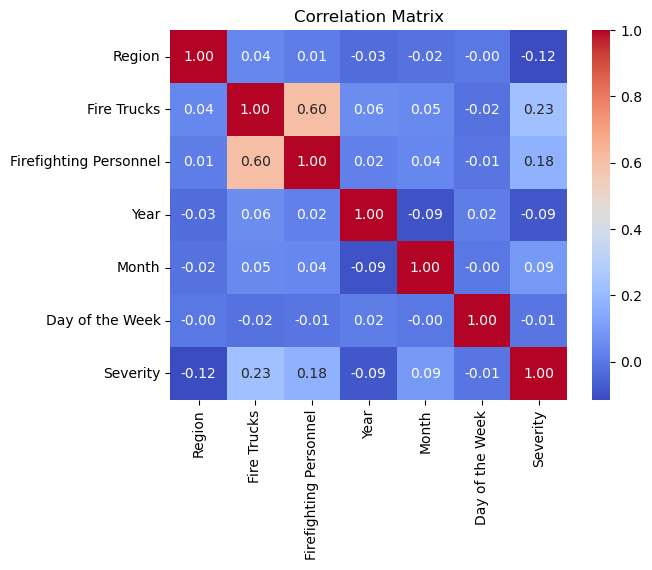

In [3]:
# correlation matrix
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

The heatmap above shows that most features are weakly correlated to each other. Even though some correlation can be observed between Fire Trucks, Firefighting personnel and Severity, XGBoost handles well correlated data, so we can continue with further modelling. 

https://xgboosting.com/xgboost-robust-to-correlated-input-features-multi-collinearity/ 

### Data split and standarization

In [4]:
y = df[['Fire Trucks', 'Firefighting Personnel']]
X = df[['Region', 'Year', 'Month', 'Day of the Week', 'Severity']]

In [5]:
# standarization, for interpretability we scale only the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [6]:
# data split, test size = 0.3
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X_scaled, y, test_size=0.3, shuffle=True, random_state=42)

### Baseline model

For the baseline model a linear regression was selected. Additionally, several models were implemented to see how they perform and make an informed decision about further modelling. The models were implemented with very few 'default' parameters. The metric used is Root Mean Squared Error, as it well indicates the performance of a regression model.

In [9]:
# linear regression
linregr = LinearRegression()
linregr.fit(X_train, y_train)
y_pred = linregr.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error:", rmse)


Root Mean Squared Error: 14.929002915765736


In [10]:
# ridge regression
ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3])
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
rmse_ridge = root_mean_squared_error(y_test, y_pred_ridge)
print("Root Mean Squared Error:", rmse_ridge)

Root Mean Squared Error: 14.929020145567506


In [11]:
# random forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train[['Fire Trucks', 'Firefighting Personnel']])
y_pred_rf = rf.predict(X_test)
rmse_rf = root_mean_squared_error(y_test[['Fire Trucks', 'Firefighting Personnel']], y_pred_rf)
print("Root Mean Squared Error:", rmse_rf)

Root Mean Squared Error: 14.78239771525729


In [12]:
# xgboost
xgb = XGBRegressor(n_estimators=50, random_state=42)
xgb.fit(X_train, y_train[['Fire Trucks', 'Firefighting Personnel']])
y_pred_xgb = xgb.predict(X_test)
rmse_xgb = root_mean_squared_error(y_test[['Fire Trucks', 'Firefighting Personnel']], y_pred_xgb)
print("Root Mean Squared Error (XGBoost):", rmse_xgb)

Root Mean Squared Error (XGBoost): 14.483978271484375


The performance of the model improved very slightly with every model, ending up with the best score for the XGBoost. In the next steps we we will tune the parameters of this model to obtain better results.

## XGBoost model

### Parameter tuning

The tuning of XGBoost parameters was conducted using Randomized Search, as it is very efficient. The values of parameters are chosen based on the observations and previous experiments with the model.


In [13]:
# parameters for random search
param_dist = {
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [3, 5, 7, 9],
    'learning_rate': [0.05, 0.1],
    'n_estimators': randint(100, 400),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(1, 4)
}

In [14]:
# random search
model = XGBRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=30, scoring= 'neg_root_mean_squared_error', cv=5, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best RMSE: ", -random_search.best_score_)

Best parameters found:  {'colsample_bytree': np.float64(0.6186662652854461), 'gamma': np.float64(0.4868777594207296), 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 274, 'reg_alpha': np.float64(0.6183860093330873), 'reg_lambda': np.float64(2.529847965068651), 'subsample': np.float64(0.9932923543227152)}
Best RMSE:  10.08288516998291


### The prediction

In [15]:
# fit model with best parameters
best_params = random_search.best_params_
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])

best_model = XGBRegressor(
	max_depth=int(best_params['max_depth']),
	n_estimators=int(best_params['n_estimators']),
	min_child_weight=best_params['min_child_weight'],
	learning_rate=best_params['learning_rate'],
	subsample=best_params['subsample'],
	colsample_bytree=best_params['colsample_bytree'],
	gamma=best_params['gamma'],
	reg_alpha=best_params['reg_alpha'],
	reg_lambda=best_params['reg_lambda'],
	objective='reg:squarederror',
	verbosity=0
)
best_model.fit(X_train, y_train[['Fire Trucks', 'Firefighting Personnel']], verbose=False)
y_pred_best = best_model.predict(X_test)
y_pred_best = pd.DataFrame(y_pred_best, columns=['Fire Trucks', 'Firefighting Personnel'])
y_pred_best

,Fire Trucks,Firefighting Personnel
0,2.478908,5.838980
1,2.222644,5.834997
2,7.123608,23.592928
3,2.804055,8.998922
4,3.759310,8.917629
...,...,...
33692,1.826461,4.016303
33693,1.152497,2.802924
33694,1.918053,4.345179
33695,2.751972,6.107438


In [16]:
# round the predictions
y_pred_best_round = y_pred_best.round(0).astype(int)

In [17]:
# output
output_forecast = y_pred_best_round
output_forecast

,Fire Trucks,Firefighting Personnel
0,2,6
1,2,6
2,7,24
3,3,9
4,4,9
...,...,...
33692,2,4
33693,1,3
33694,2,4
33695,3,6


## RESULTS and CONCLUSIONS ##

Linear Regression error: 14.929

Ridge Regression error: 14.929

Random Forest error: 14.782

Default XGBoost error: 14.484

Tuned XGBoost error: 10.083


The results above show that XGBoost model with well-tuned parameters performs significantly better than the baseline Linear Regression, or other implemented models. Thanks to the Random Search tuning, the performance of the XGBoost has improved by 30%, which is an important increase.

The next step in modelling the wildfire resources data could be implementing and fitting a neural network. Due to time limitations, in this notebook we have focused solely on XGBoost.